# Interaction Convolution [상호작용을 반영한 convolution]

convolution 에서 filter [W] 는 학습될 수 있는 가중치이고,
image patch[X] 와 곱해져 feature map 을 생성한다.

이것은 내가 이해하기로는 image_patch 는 data 고, 
filter는 beta 값인 채로 linear regression 혹은 linear transform, affine transform 과 같다.

그렇다면 선형 회귀에서 사용하듯 interaction term(상호작용 항)을 고려하면 주변 픽셀들 간에 interaction 에 대한 weight 를 학습할 수 있지 않을까?

내가 단순하게 구현해보기론 X.T * X 로 feature map 혹은 input 에 대한 interaction 을 구하고 그 interaction 에 대한 convolution을 다시 함으로써 feature map 을 구할 수 있고, 
이것을 원래의 feature map과 더함으로써
상호작용 항이 고려된 feature map 을 구할 수 있을 거라 생각한다.

cifar10 학습해본 결과

일반적인 cnn 보다 학습이 조금 더 빨리 되는 것을 알 수 있었다.

------------------------------------------------------------------------------------------------------------------
foot translation

In convolution, filter[W] is learnable weight, and then feature map produced by that image patch multiply filter 

I think image_patch is data, filter is coefficient, and then it is linear regression or linear transform, affine transform.

If we take the interaction term as in linear regression, can we learn the weight of the interaction between the neighboring pixels?

I simply implement it, input or feature map is X.T * X, convolution it produce feature map. 

It add original feature map, produce feature map with interacion.

Cifar10 results

It faster than original cnn

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
tf.set_random_seed(777) 
import cifar10

In [2]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [3]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [4]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [5]:
def random_batch(train_batch_size):
    # 학습 데이터셋 안에 이미지 수
    num_images = len(images_train)

    # 무작위 인덱스 만들기
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # 무작위 인덱스를 이용해 이미지와 라벨을 선택함
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

# 상호작용이 반영된 CNN

Epoch: 0001 cost = 1.525525022
Epoch: 0002 cost = 1.257694640
Epoch: 0003 cost = 1.166033215
Epoch: 0004 cost = 1.101056453
Epoch: 0005 cost = 1.059084578
Epoch: 0006 cost = 1.011964905
Epoch: 0007 cost = 0.968527456
Epoch: 0008 cost = 0.956996769
Epoch: 0009 cost = 0.932130665
Epoch: 0010 cost = 0.913818698


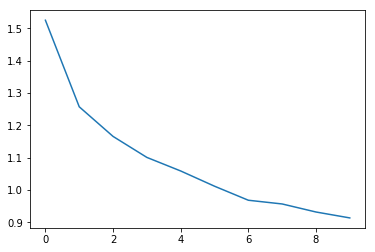

Accuracy: 0.5764


In [6]:
tf.reset_default_graph()
X_img = tf.placeholder(tf.float32, shape=[None, 32,32,3])
X = tf.reshape(X_img, [-1,32,32,3])
Y = tf.placeholder(tf.uint8 , shape = [None , 10])
conv1 = tf.layers.conv2d(X,32,3,activation=tf.nn.elu)
conv11_interaction = tf.layers.conv2d(tf.multiply(X, tf.transpose(X,[0,2,1,3])),32,3,activation=tf.nn.elu)
conv11_add = tf.add(conv1,conv11_interaction)
conv11_pooling = tf.layers.max_pooling2d(conv11_add,2,2)
conv11_flatten = tf.reshape(conv11_pooling,[-1,conv11_pooling.get_shape()[1:4].num_elements()])
dense1 = tf.layers.dense(conv11_flatten,128)
dense2 = tf.layers.dense(dense1,10)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=dense2))
optimizer = tf.train.AdamOptimizer().minimize(cost)
costs = []
batch_size = 32
training_epochs = 10
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(images_train.shape[0] / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = random_batch(batch_size)
        feed_dict = {X_img: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
    costs.append(avg_cost)
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
plt.plot(costs)
plt.show()
correct_prediction = tf.equal(tf.argmax(dense2, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X_img: images_test, Y: labels_test}))

# 일반적인 CNN

Epoch: 0001 cost = 1.502513721
Epoch: 0002 cost = 1.260068155
Epoch: 0003 cost = 1.169101817
Epoch: 0004 cost = 1.109899973
Epoch: 0005 cost = 1.067770822
Epoch: 0006 cost = 1.027605854
Epoch: 0007 cost = 0.998852198
Epoch: 0008 cost = 0.978262731
Epoch: 0009 cost = 0.948536852
Epoch: 0010 cost = 0.939814833


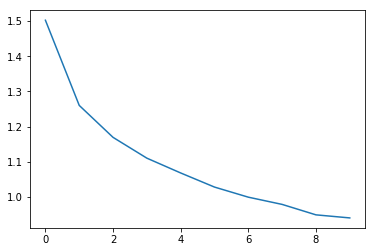

Accuracy: 0.5875


In [7]:
tf.reset_default_graph()
X_img = tf.placeholder(tf.float32, shape=[None, 32,32,3])
X = tf.reshape(X_img, [-1,32,32,3])
Y = tf.placeholder(tf.uint8 , shape = [None , 10])
conv1 = tf.layers.conv2d(X,32,3,activation=tf.nn.elu)
conv11_pooling = tf.layers.max_pooling2d(conv1,2,2)
conv11_flatten = tf.reshape(conv11_pooling,[-1,conv11_pooling.get_shape()[1:4].num_elements()])
dense1 = tf.layers.dense(conv11_flatten,128)
dense2 = tf.layers.dense(dense1,10)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=dense2))
optimizer = tf.train.AdamOptimizer().minimize(cost)
costs = []
batch_size = 32
training_epochs = 10
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(images_train.shape[0] / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = random_batch(batch_size)
        feed_dict = {X_img: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
    costs.append(avg_cost)
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
plt.plot(costs)
plt.show()
correct_prediction = tf.equal(tf.argmax(dense2, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy:', sess.run(accuracy, feed_dict={
      X_img: images_test, Y: labels_test}))